#Performance Measures


Hasta ahora vimos algunas formas de clasificar, veamos un poco más de detalle en como podemos hacer para "medir" que tan bien funciona un clasificador binario.

Primero, unas celdas de preparación.


In [25]:
from sklearn.base import BaseEstimator
import numpy as np
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


np.random.seed(42)

#Clasificador pulenta (spoiler: No, no lo es)
class ClasificadorGroso(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

# to make this notebook's output stable across runs

def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

Volvamos al conjunto de MNIST de la clase pasada. Recordemos que son unas 70 000 imágenes pequeñas de dígitos manuscritos con sus correspondientes etiquetas.

Los bajamos y acomodamos para tener nuestros conjuntos X y t


In [26]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')

# Datos y etiquetas
X, t = mnist["data"], mnist["target"]
# Separamos en entrenamiento y testeo
X_train, X_test, t_train, t_test = X[:60000], X[60000:], t[:60000], t[60000:]

#Mezclar el entrenamiento, para que todo esté bien representado

shuffle_index = np.random.permutation(60000)
X_train, t_train = X_train[shuffle_index], t_train[shuffle_index]


## Problema de decisión
En el ejemplo de la clase pasada de transformó esto en un problema de decisión donde lo que se buscaba era detectar cincos. 

Habia que acomodar las etiquetas para eso:


In [27]:
# transformamos para clasificación binaria, si es 5 la etiqueta es True
t_train_5 = (t_train == 5)
t_test_5 = (t_test == 5)

En las celdas de preparación hay definido un clasificador que aseguran que es buenísimo (**ClasificadorGroso**), vamos a probarlo con este conjunto de entrenamiento a ver que nos da la validación cruzada.

In [28]:
from sklearn.model_selection import cross_val_score

clasificador_groso = ClasificadorGroso()

scores = cross_val_score(clasificador_groso, X_train, t_train_5, cv=3,scoring="accuracy")
print("Scores:", scores)
print("Media:", scores.mean())


Scores: [0.909   0.90715 0.9128 ]
Media: 0.90965


Un 90% de accuracy! nada mal, debe ser groso posta

............ _pausa dramática_ ............ 

¿o no?

Este era el código del clasificador pulenta:

In [29]:
class ClasificadorGroso(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X), 1), dtype=bool)

Claramente no es el habil clasificador que pensábamos, pero en nuestra forma de evaluarlo nos dio bastante bien. 

¿Hay un problema? ¿Es el clasificador? ¿Es el conjunto?

Nop, es la métrica.

Pensemos que significaba el accuracy:

$$
\mathrm{accuracy} = \frac{Aciertos}{Totales}
$$

$$
\mathrm{accuracy} = \frac{TP + TN}{TP+TN+FP+FN}
$$




In [30]:
cincos = np.count_nonzero(t_train_5 == True)
no_cincos = np.count_nonzero(t_train_5 == False)
ratio_no_cincos = no_cincos / (cincos + no_cincos)

print("Cantidad de 5:", cincos)
print("Cantidad de no 5:", no_cincos)
print("Porcentaje \"No Cincos\":", ratio_no_cincos)

Cantidad de 5: 5421
Cantidad de no 5: 54579
Porcentaje "No Cincos": 0.90965


## Matriz de confusión - Precisión/Exhaustividad

En conjunto está severamente desbalanceado, y el accuracy está dando bien porque el conjunto tienen un 90% de "No cincos". 

Que nos haya dado "Bien" un clasificador que no hace nada es porque lo estábamos analizando mal, hay que usar una métrica distinta.

Una mejor manera de evaluar la performance de un clasificador es ver la *matriz de confusión*.

Se predice sobre todo el conjunto y luego se muestran los resultados en una matriz que tiene en las filas los valores de cada clase del conjunto y en las columnas las predicciones del método en cuestión. Se puede implementar facil, pero (como casi todo) sklearn ya la trae:



In [31]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict

#Usamos CV para calcular las predicciones

clasificador_groso = clasificador_groso.fit(X_train, t_train_5)
t_train_pred_CG = cross_val_predict(clasificador_groso, X_train, t_train_5, cv=5)

cm = confusion_matrix(t_train_5, t_train_pred_CG)

print(cm)

[[54579     0]
 [ 5421     0]]


Solo para mostrarla más linda, usamos un código prestado de stackoverflow:






In [32]:
import pandas as pd

#código para mostrar las matrices de confusión más bonitas
#https://stackoverflow.com/questions/50325786/sci-kit-learn-how-to-print-labels-for-confusion-matrix

def cm2df(cm, labels):
    df = pd.DataFrame()
    # rows
    for i, row_label in enumerate(labels):
        rowdata={}
        # columns
        for j, col_label in enumerate(labels): 
            rowdata[col_label]=cm[i,j]
        df = df.append(pd.DataFrame.from_dict({row_label:rowdata}, orient='index'))
    return df[labels]

cm_groso = cm2df(cm, ["No cinco", "Cinco"])
print(cm_groso)


          No cinco  Cinco
No cinco     54579      0
Cinco         5421      0


Ahora si, viendo la matriz se nota lo que estaba haciendo el "clasificador", jamás le pegó a un cinco :P.

Probemos el perceptrón que hizo Rodrigo la clase pasada:

In [36]:
from sklearn.linear_model import Perceptron

perce = Perceptron()
phi = X_train.copy()

scores = cross_val_score(perce, phi, t_train_5, cv=5, scoring="accuracy")
print("Scores:",scores)
print("Media (recordemos que es accuracy):",scores.mean())

Scores: [0.968      0.96225    0.96166667 0.95391667 0.97316667]
Media (recordemos que es accuracy): 0.9638


El accuracy da más alto que con el "clasificador groso", peeeeeero con este conjunto ya no le creemos mucho. 

In [38]:
t_train_pred_perce = cross_val_predict(perce, phi, t_train_5, cv=5)

cm_perceptron = confusion_matrix(t_train_5, t_train_pred_perce)
cm_perceptron_linda = cm2df(cm_perceptron, ["No cinco", "Cinco"])

print(cm_perceptron_linda)


          No cinco  Cinco
No cinco     53627    952
Cinco         1220   4201


Viendo la matriz de confusión parece que va bien (tampoco era tan dificil, claro), pero ¿qué seria "ir bien"?. 

A veces conviene definir alguna métrica un poco más concisa.

Se puede ver el ***accuracy de las predicciones positivas*** o como le decimos en el barrio: **precision (precisión)**.


$$
\mathrm{precision} = \frac{TP}{TP + FP}
$$

**TP** -> True positives (Verdaderos positivos): "*Era cinco y dijiste cinco*"

**FP** -> False positives (Falsos positivo): "*No era cinco y dijiste cinco*"



***
Para charlar: 

*   ¿Qué nos dice este número? 
*   ¿Entre qué valores se mueve?
*   ¿Qué significa cuando está cerca de cada borde?
*   ¿De donde puedo sacar los valores de FP y TP?
***

Se pueden hacer las cuentas a mano, usar funciones de sklearn o sacar los datos directamente de la matriz de confusión:

In [39]:
tp = cm_perceptron[1, 1]
fp = cm_perceptron[0, 1]

print('Precision: ', tp/(tp + fp))

Precision:  0.8152532505336697


Otra métrica importante Recall (Exhaustividad):

$$
\mathrm{recall} = \frac{TP}{TP + FN}
$$

**TP** -> True positives (Verdaderos positivos): "*Era cinco y dijiste cinco*"

**FP** -> False negatives (Falsos negativos): "*Era cinco y dijiste que no era*"

***
Para charlar: 

*   ¿Qué nos dice este número? 
*   ¿Entre qué valores se mueve?
*   ¿Qué significa cuando está cerca de cada borde?
***
Gerón tiene una buena imagen para relacionar la matriz de confusión con esto:




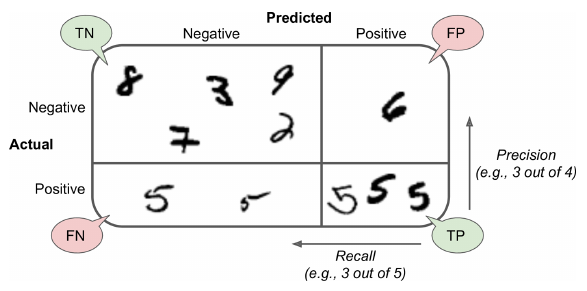




Ahora calculemos todo junto

In [40]:
tp = cm_perceptron[1, 1]
fp = cm_perceptron[0, 1]
fn = cm_perceptron[1, 0]

print('Precision:', tp/(tp + fp))
print('Recall:', tp/(tp + fn))

Precision: 0.8152532505336697
Recall: 0.7749492713521491


¿Cómo se lee?

"*Cuando el perceptrón dice que una imagen es un 5, la pega el 81% de las veces*"

"Detecta el 77% de los 5 que hay en la muestra"

Obviamente hay función de sklearn para hacerlo directo sin pasar por la matriz.

In [41]:
from sklearn.metrics import precision_score, recall_score

print("Precision:",precision_score(t_train_5, t_train_pred_perce))
print("Recall:",recall_score(t_train_5, t_train_pred_perce))


Precision: 0.8152532505336697
Recall: 0.7749492713521491


## Precision/Recall Trade-off

Pensemos un segundo en estos valores por separado, ¿qué tan dificil puede ser tener mucha precisión? ¿y mucha exhaustividad?


In [47]:
class ClasificadorExhaustivo(BaseEstimator):
  def fit(self, X, y=None):
    return self
  def predict(self, X):
    return np.ones((len(X), 1), dtype=bool)

clasificador_exhaustivo = ClasificadorExhaustivo()

clasificador_exhaustivo = clasificador_exhaustivo.fit(X_train, t_train_5)
exhaustivo_pred = cross_val_predict(clasificador_exhaustivo, X_train, t_train, cv=5)

# tambien se puede predecir directamente, pero mejor con CV
#exhaustivo_pred = clasificador_exhaustivo.predict(X_train)

print("Recall:",recall_score(t_train_5, exhaustivo_pred))


Recall: 1.0


¿Y la precisión?

In [44]:
print("Precision:",precision_score(t_train_5, exhaustivo_pred))


Precision: 0.09035



Lamentablemente no se puede tener todo en esta vida(?) y si queremos más precisión vamos a pagar con menos exhaustividad, y viceversa.

Esto se llama *precision/recall trade-off* y tiene que ver con el umbral de decisión. 

En el perceptrón para una instancia dada se calcula un valor (score), ese valor se pasa por la función de activación y si es menor que cero será de una clase y de la otra si es mayor. 
Si pudiésemos mover este umbral cambiaríamos la precisión y la exhaustividad.


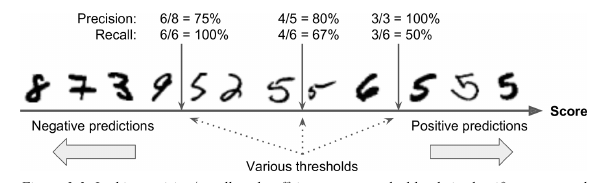

(Gracias por tanto, Geron. Perdón por tan poco...)

Sklearn no nos deja tocar el umbral directamente, pero si nos da acceso a los scores que usa para hacer las predicciones. 

Text(0.5, 0, 'Scores')

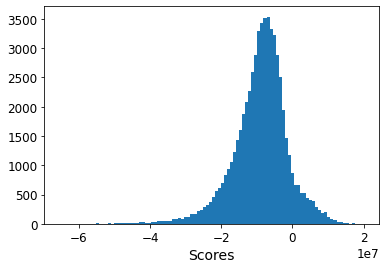

In [45]:
perce = perce.fit(phi, t_train_5)

# Se puede hacer directamente así
#scores = perce.decision_function(X_train)

# Pero mejor con CV
y_scores = cross_val_predict(perce, X_train, t_train_5, cv=3, method="decision_function")

A = plt.hist(y_scores, 100)
plt.xlabel('Scores')



Relacionemos los scores con las imágenes


Score: -14451727.0
Decisión Perceptrón: [False]
Etiqueta: False


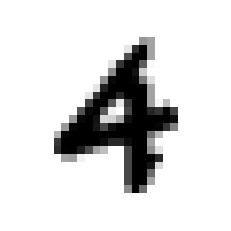

In [48]:
no_cinco = 19000

plot_digit(X_train[no_cinco])
print("Score:",y_scores[no_cinco])
print("Decisión Perceptrón:",perce.predict([X_train[no_cinco]]))
print("Etiqueta:", t_train_5[no_cinco])



Score: 9370428.0
Decisión Perceptrón: [ True]
Etiqueta: True


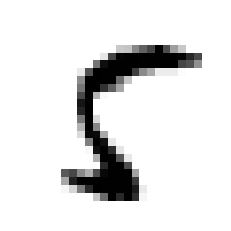

In [ ]:
cinco = 19

plot_digit(X_train[cinco])
print("Score:",y_scores[cinco])
print("Decisión Perceptrón:",perce.predict([X_train[cinco]]))
print("Etiqueta:", t_train_5[cinco])


Score: 1884371.0
Decisión Perceptrón: [ True]
Etiqueta: False


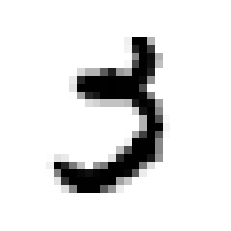

In [ ]:
quasi_cinco = 26

plot_digit(X_train[quasi_cinco])
print("Score:",y_scores[quasi_cinco])
print("Decisión Perceptrón:",perce.predict([X_train[quasi_cinco]]))
print("Etiqueta:", t_train_5[quasi_cinco])


Veamos como efectivamente cambia la precisión y la exhaustividad cuando tocamos el umbral.

Se genera un vector de 5000 umbrales y para cada uno se calculan ambos valores:

In [49]:
umb = np.linspace(y_scores.min()-1, y_scores.max()+1, 5000)

recall = np.zeros_like(umb)
precision = np.zeros_like(umb)
fpr = np.zeros_like(umb)

for i, u in enumerate(umb):
    
    # Calcula los índices con detecciones para este umbral
    det = y_scores > u
    
    # Compara esto con los verdaderos casos en esos índices

    tp = np.sum(t_train_5[det] == True)
    # Falsos positivos
    fp = np.sum(t_train_5[det] == False)

    # Verdaderos y falsos negativos
    tn = np.sum(t_train_5[~det] == False)
    fn = np.sum(t_train_5[~det] == True)
    
    recall[i] = tp/(tp + fn)
    precision[i] = tp/(tp + fp)
    fpr[i] = fp/(fp + tn)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in long_scalars


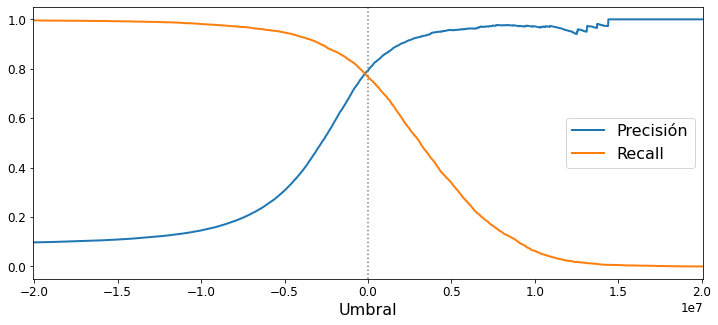

In [ ]:
fig = plt.figure(figsize=(12, 5))
plt.plot(umb, precision, label='Precisión', lw=2)
plt.plot(umb, recall, label='Recall', lw=2)
plt.xlabel("Umbral", fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.xlim(-umb.max(), umb.max())
plt.axvline(0.0, ls=':', color='0.5')
plt.show()

Otra forma de verlo es usando una curva PR (Precision/Recall). Para cada umbral se grafican ambos resultados. 


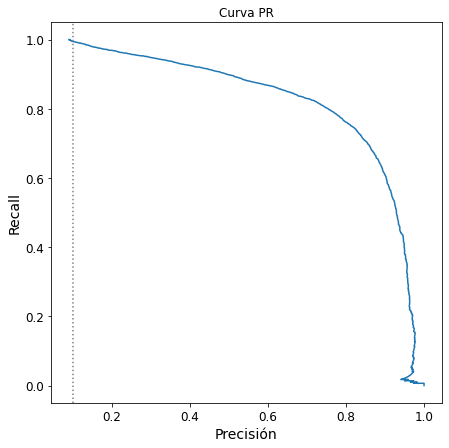

In [ ]:
fig = plt.figure(figsize=(7, 7))
plt.plot(precision, recall)
plt.axvline(0.1, ls=':', color='0.5')
plt.xlabel('Precisión')
plt.ylabel('Recall')
plt.title('Curva PR')
plt.show()

Ahora lo podemos usar para ajustar al problema que estamos resolviendo. Supongamos que queremos una precisión del 90%, podemos buscar el umbral acorde:



In [51]:
threshold_90_precision = umb[np.argmax(precision >= 0.90)]
print(threshold_90_precision)


1956553.778355673


In [52]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_90 = precision_score(t_train_5, y_train_pred_90)
recall_90 = recall_score(t_train_5, y_train_pred_90)

print("Precisión:", precision_90)
print("Exhaustividad:", recall_90)



Precisión: 0.900492072170585
Exhaustividad: 0.6076369673491976


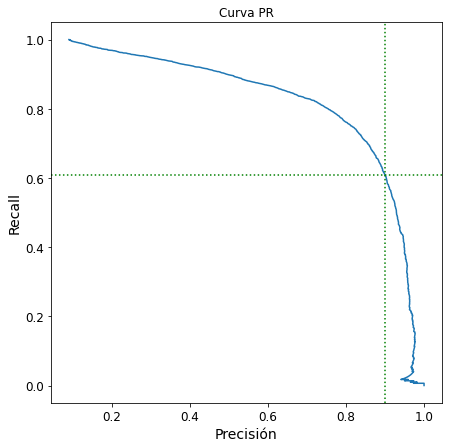

In [53]:
fig = plt.figure(figsize=(7, 7))
plt.plot(precision, recall)
plt.axvline(precision_90, ls=':', color='green')
plt.axhline(recall_90, ls=':', color='green')
plt.xlabel('Precisión')
plt.ylabel('Recall')
plt.title('Curva PR')
plt.show()


Con esto podemos elegir el umbral que mejor funcione al problema en particular que estamos resolviendo. 

Ejemplos de siempre: filtro antispam, filtro de niños en youtube, etc.

Un dato importante que se puede sacar de esto es el AUC (Area Under the Curve). Que nos da una idea general del clasificador, cuanto más cerca de 1 esté este valor, mejor va a ser.

Veamos todo esto en la opción sklearn


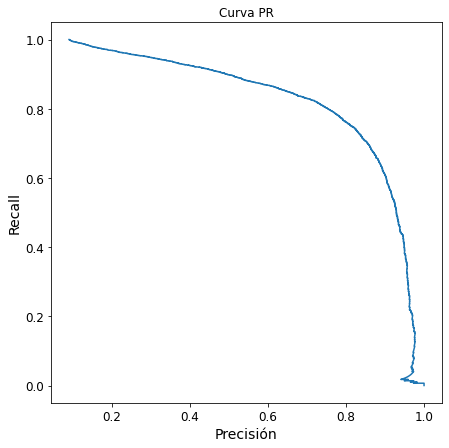

AUC: 0.8340099563962218


In [54]:
from sklearn.metrics import precision_recall_curve, auc, roc_auc_score, plot_precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(t_train_5, y_scores)

fig = plt.figure(figsize=(7, 7))
plt.plot(precisions, recalls)
plt.xlabel('Precisión')
plt.ylabel('Recall')
plt.title('Curva PR')
plt.show()
auc_score = auc(recalls, precisions)
print("AUC:", auc_score)


# Otra opción que plotea directamente
# plot_precision_recall_curve(perce, X_train, t_train_5)




## Receiver Operating Characteristic (ROC) 

La ROC  (Receiver Operating Characteristic, o Característica Operativa del Receptor) es otra herramienta muy usada con clasificadores binarios. Es muy parecida la curva PR, pero en vez de plotear la precisión contra la exhaustividad lo hace entre la tasa de verdaderos positivos (otro nombre para la exhaustividad) contra la tasa de falsos positivos (FPR). El FPR es la razón de las instancias negativas que son erroneamente marcadas como positivas.
Cuanto más alejado de la recta unidad esté el sistema mejor, pero por supuesto esto depende del problema a resolver.


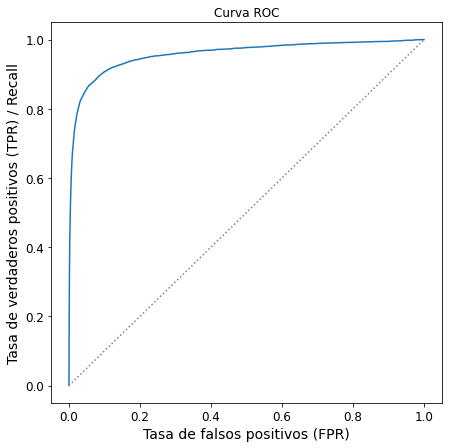

AUC: 0.9580193643308677


In [ ]:
fig = plt.figure(figsize=(7, 7))
plt.plot(fpr, recall)
plt.plot([0, 1], [0, 1], color='0.5', ls=':')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR) / Recall')
plt.title('Curva ROC')
plt.show()

#se le pasan las etiquetas y los scores
roc_auc = roc_auc_score(t_train_5, y_scores)
print("AUC:", roc_auc)


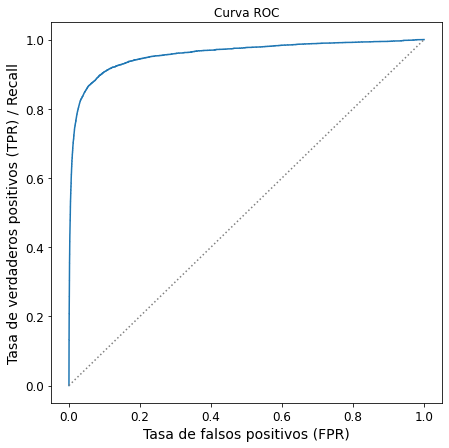

In [55]:
# versión sklearn

from sklearn.metrics import plot_roc_curve, roc_curve

fpr, tpr, thresholds = roc_curve(t_train_5, y_scores)

fig = plt.figure(figsize=(7, 7))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='0.5', ls=':')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR) / Recall')
plt.title('Curva ROC')
plt.show()

# O usar directamente la funcion para plotearla
# plot_roc_curve(perce, X_train, t_train_5)


## Comparaciones

Otra gran útilidad de estas herramientas es para poder comparar dos clasificadores. Vamos a instanciar un random forest(*), y vamos a compararlo con el perceptrón.


(*) Lo vamos a ver en detalle más adelante, por ahora alcanza con saber que dada una imagen nos va a dar una probabilidad de a que clase pertenece).



In [56]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, t_train_5, cv=3, method="predict_proba")


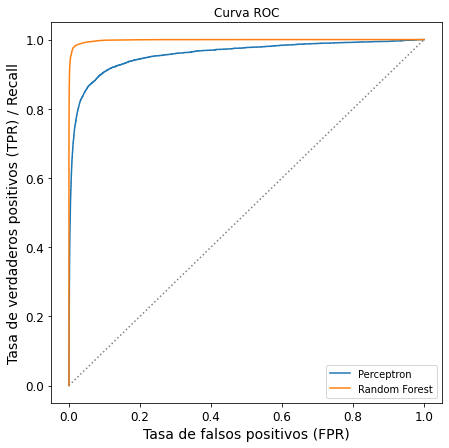

AUC Perceptrón: 0.9580193643308677
AUC RF: 0.9983730844244434


In [61]:
y_scores_forest = y_probas_forest[:, 1]

fpr_forest, tpr_forest, thresholds_forest = roc_curve(t_train_5,y_scores_forest)

#Grafiquemos el RF contra el Perceptrón

fig = plt.figure(figsize=(7, 7))
plt.plot([0, 1], [0, 1], color='0.5', ls=':')
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR) / Recall')
plt.title('Curva ROC')
plt.plot(fpr, tpr, label='Perceptron')
plt.plot(fpr_forest, tpr_forest, label='Random Forest')
plt.legend(loc="lower right")
plt.show()

roc_auc_perce = roc_auc_score(t_train_5, y_scores)
roc_auc_rf = roc_auc_score(t_train_5, y_probas_forest[:, 1])
print("AUC Perceptrón:", roc_auc_perce)
print("AUC RF:", roc_auc_rf)



Claramente la ROC y el AUC del random forest dio mejor que la del perceptrón. Sin embargo se suele preferir una curva PR cuando la clase positiva es más escasa o cuando te preocupan más los falsos positivos que los falsos negativos.

Miremos el caso del perceptrón, el aŕea debajo de la curva en la ROC dió muy bien, pero esto es porque hay pocos cincos. Viendo la curva PR se puede ver que todavia se puede mejorar.

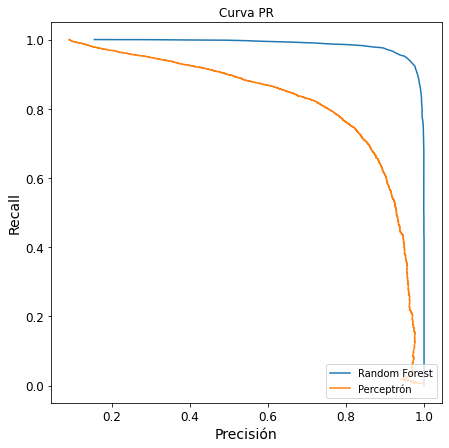

AUC RF: 0.988473102015905
AUC Perceptrón: 0.8340099563962218
Precisión RF: 0.9888748950461796
Exhaustividad RF: 0.8690278546393654


In [63]:
precisions_rf, recalls_rf, thresholds_rf = precision_recall_curve(t_train_5,y_scores_forest)
precisions_perce, recalls_perce, thresholds_perce = precision_recall_curve(t_train_5, y_scores)

y_preds=cross_val_predict(forest_clf, X_train, t_train_5, cv=3, method="predict")

fig = plt.figure(figsize=(7, 7))
plt.plot(precisions_rf, recalls_rf, label="Random Forest")
plt.plot(precisions_perce, recalls_perce, label="Perceptrón")
plt.xlabel('Precisión')
plt.ylabel('Recall')
plt.title('Curva PR')
plt.legend(loc="lower right")
plt.show()

auc_score_rf = auc(recalls_rf, precisions_rf)
auc_score_perce = auc(recalls_perce, precisions_perce)

print("AUC RF:", auc_score_rf)
print("AUC Perceptrón:", auc_score_perce)
print("Precisión RF:", precision_score(t_train_5,y_preds))
print("Exhaustividad RF:", recall_score(t_train_5,y_preds))


## Resumiendo

Para poder evaluar un clasficador hay que tener en cuenta varias factores que van más allá de solo ver un número resultado. Hay que analizar el conjunto de datos, determinar que nos interesa más del tipo de problema que estamos resolviendo y evaluar diferentes métricas hasta encontrar la más adecuada. Hay muchas más que se podrian usar acá (*F1-Score, Balanced accuracy*) pero la metodología de trabajo siempre es muy similar.


